# K-Nearest Neighbors vs. ideale Regressionsfunktion
Aus den Grundlagen des Machine Learnings ist bekannt, dass ein Zusammenhang zwischen k-Nearest-Neighbor (kNN) und der idealen Regressionsfunktion hergestellt werden kann. In dieser Arbeit soll anhand von selbst erzeugten, synthetischen Daten untersucht werden, wie stark kNN von der idealen Mittelwertschätzung abweicht. Dabei sollen folgende Faktoren berücksichtigt werden: k, die Varianz des Modells (eventuell auch heteroskedastisch), die vorgegebene Mittelwertsfunktion und die Dimension der Daten.

In [14]:
### ----- IMPORTS ----- ###

import numpy as np
from dataclasses import dataclass
from typing import Callable, Dict, Optional, Tuple
from enum import Enum
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


## Datengenerierung

### Mittelwertfunktionen
Bestimmen die ground-truth:
- Sinus-Funktion (1D, easy)
- Lineare Summe (mehrdimensional, linear, je größer die Eingaben X desto größer y)
-  Product-sine (komplex, mehrdimensional, könnte Grenzen von kNN aufzeigen, vor allem bei lokalen Methoden)
- piecewise-1D (Sprungfunktion, plötzliche Wechsel und keine Glätte, verwaschene Mittelwerte)

In [4]:
def mean_sine_1d(X: np.ndarray) -> np.ndarray:
    # INPUT: 1D-Array
    # OUTPUT: nichtlineare Mittelwertfunktion mit einer Sinusperiode auf [0,1]

    x = X[:, 0]
    return np.sin(2 * np.pi * x)

def mean_sum_linear(X: np.ndarray) -> np.ndarray:
    # INPUT: n-Dimensionales Array
    # OUTPUT: Summe aller Werte in jedem Datenpunkt x_i in X

    return np.sum(X, axis=1)

def mean_product_sine(X: np.ndarray) -> np.ndarray:
    # INPUT: Mehrdimensionales Array
    # OUTPUT: Nichtlineare Mittelwertfunktion: Produkt von Sinus-Terms über alle Dimensionen

    return np.prod(np.sin(np.pi * X), axis=1)

def mean_piecewise_1d(X: np.ndarray) -> np.ndarray:
    # INPUT: 1D-Array
    # OUTPUT: Stückweise konstante 1D-Funktion mit Sprung bei x=0.5
        # f(x) = 0 für x <= 0.5
        # f(x) = 1 für x >= 0.5

    x = X[:, 0]
    return np.where(x < 0.5, 0.0, 1.0)

### Rauschfunktionen
Fügen der ground-truth Rauschen hinzu (für Simulation):
- sigma_constant: Jeder Punkt hat gleiche Standardabweichung (homoskedastisch)
- siga_linear_in_first_dim: Standardabweichung wächst linear mit x (heteroskedastisch, nützlich im 1D Raum, da anschaulich)
- sigma_radial: Standardabweichung abhängig von Distanz zum Zentrum (heteroskedastisch, funktioniert für höhere Dimensionen)

In [5]:
def sigma_constant(X: np.ndarray, sigma: float) -> np.ndarray:
    n = X.shape[0]
    return np.full(n, float(sigma))

def sigma_linear_in_first_dim(X: np.ndarray, sigma_min: float, sigma_max: float) -> np.ndarray:
    x_0 = X[:, 0]
    return sigma_min + (sigma_max - sigma_min) * x_0

def sigma_radial(X: np.ndarray, sigma_min: float, sigma_max: float) -> np.ndarray:
    center = 0.5
    r = np.linalg.norm(X - center, axis=1)
    r_norm = r / (np.sqrt(X.shape[1] * 0.5))
    r_norm = np.clip(r_norm, 0.0, 1.0)
    return sigma_min + (sigma_max - sigma_min) * r_norm

### Konfiguration
Definition einer Datengenerierungs-Konfiguration in einer Klasse

In [6]:
class NOISE_FN_TYPE(Enum):
    HOMO = "HOMOS"
    HETERO_LINEAR = "HETERO_LINEAR"
    HETERO_RADIAL = "HETERO_RADIAL"

class MEAN_FN_TYPE(Enum):
    SINE_1D = "SINE_1D"
    SUM_LINEAR = "SUM_LINEAR"
    PRODUCT_SINE = "PRODUCT_SINE"
    PIECEWISE_1D = "PIECEWISE_1D"

class DISTRIBUTION_TYPE(Enum):
    UNIFORM_01 = "UNIFORM_01"

MEAN_FUNCTIONS: Dict[MEAN_FN_TYPE, Callable[[np.ndarray], np.ndarray]] = {
    MEAN_FN_TYPE.SINE_1D: mean_sine_1d,
    MEAN_FN_TYPE.SUM_LINEAR: mean_sum_linear,
    MEAN_FN_TYPE.PRODUCT_SINE: mean_product_sine,
    MEAN_FN_TYPE.PIECEWISE_1D: mean_piecewise_1d,
}


@dataclass(frozen=True)
class DatasetConfig:
    n_train: int = 500
    n_test: int = 2000
    d: int = 1

    k: int = 5

    mean_function: MEAN_FN_TYPE = MEAN_FN_TYPE.SINE_1D
    noise_type: NOISE_FN_TYPE = NOISE_FN_TYPE.HOMO

    sigma: float = 0.2
    sigma_min: float = 0.05
    sigma_max: float = 0.5

    x_dist: DISTRIBUTION_TYPE = DISTRIBUTION_TYPE.UNIFORM_01

    seed: int = 42

### Generierungsfunktion
Erzeugt synthetische Daten basierend auf einer übergebenen Konfigurationsklasse

In [9]:
def generate_dataset(config: DatasetConfig) -> Dict[str, np.ndarray]:
    """
    Erzeugt synthetische Train/Test-Daten nach cfg.

    Returns dict mit:
      X_train, y_train
      X_test, y_test
      y_mean_train, y_mean_test  -> die ground truth (Mittelwertfunktion ohne das Rauschen)
      sigma_train, sigma_test    -> tatsächlich verwendete Standardabweichung pro Punkt
    """

    rng = np.random.default_rng(config.seed)

    match config.x_dist:
        case DISTRIBUTION_TYPE.UNIFORM_01:
            X_train = rng.uniform(0.0, 1.0, size=(config.n_train, config.d))
            X_test = rng.uniform(0.0, 1.0, size=(config.n_test, config.d))
        case _:
            raise ValueError(f"DISTRIBUTION_TYPE '{config.x_dist}' not supported.")

    if config.mean_function not in MEAN_FUNCTIONS:
        raise ValueError(f"Unbekannte mean_fn: {config.mean_function}. Verfügbar: {list(MEAN_FUNCTIONS.keys())}")

    f = MEAN_FUNCTIONS[config.mean_function]
    y_mean_train = f(X_train)
    y_mean_test = f(X_test)

    match config.noise_type:
        case NOISE_FN_TYPE.HOMO:
            sigma_train = sigma_constant(X_train, config.sigma)
            sigma_test = sigma_constant(X_test, config.sigma)
        case NOISE_FN_TYPE.HETERO_LINEAR:
            sigma_train = sigma_linear_in_first_dim(X_train, config.sigma_min, config.sigma_max)
            sigma_test = sigma_linear_in_first_dim(X_test, config.sigma_min, config.sigma_max)
        case NOISE_FN_TYPE.HETERO_RADIAL:
            sigma_train = sigma_radial(X_train, config.sigma_min, config.sigma_max)
            sigma_test  = sigma_radial(X_test,  config.sigma_min, config.sigma_max)
        case _:
            raise ValueError(f"Unknown NOISE_FN_TYPE: {config.noise_type}")

    eps_train = rng.normal(loc=0.0, scale=sigma_train, size=config.n_train)
    eps_test = rng.normal(loc=0.0, scale=sigma_test, size=config.n_test)

    y_train = y_mean_train + eps_train
    y_test = y_mean_test + eps_test

    return {
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test,
        "y_mean_train": y_mean_train,
        "y_mean_test": y_mean_test,
        "sigma_train": sigma_train,
        "sigma_test": sigma_test,
    }

### BASIC PLOTS

In [12]:
def plot_1d_dataset(data, title=""):
    X = data["X_train"][:, 0]
    y = data["y_train"]
    y_mean = data["y_mean_train"]
    sigma = data["sigma_train"]

    # Sortieren für schöne Linienplots
    idx = np.argsort(X)
    Xs = X[idx]
    y_mean_s = y_mean[idx]
    sigma_s = sigma[idx]

    plt.figure()
    plt.scatter(X, y, alpha=0.5, s=15, label="Train data")
    plt.plot(Xs, y_mean_s, linewidth=2, label="True mean f(x)")

    # Unsicherheitsband ± sigma
    plt.fill_between(
        Xs,
        y_mean_s - sigma_s,
        y_mean_s + sigma_s,
        alpha=0.3,
        label="± noise std"
    )

    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

def plot_high_dim_summary(data, title=""):
    y = data["y_train"]
    sigma = data["sigma_train"]

    plt.figure()
    plt.hist(y, bins=40, alpha=0.6)
    plt.title(f"{title} – Target distribution")
    plt.xlabel("y")
    plt.ylabel("count")
    plt.show()

    plt.figure()
    plt.hist(sigma, bins=40, alpha=0.6)
    plt.title(f"{title} – Noise std distribution")
    plt.xlabel("sigma")
    plt.ylabel("count")
    plt.show()



### MAIN

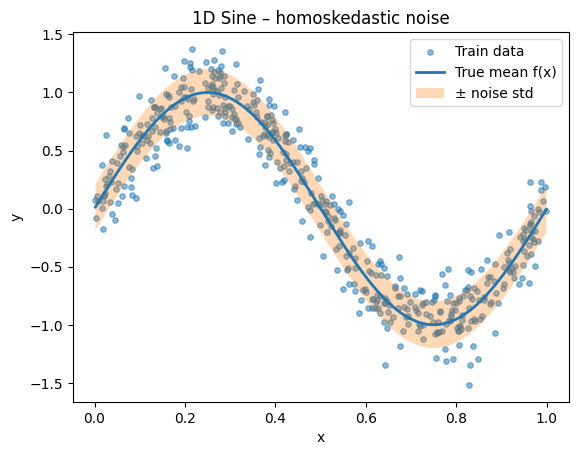

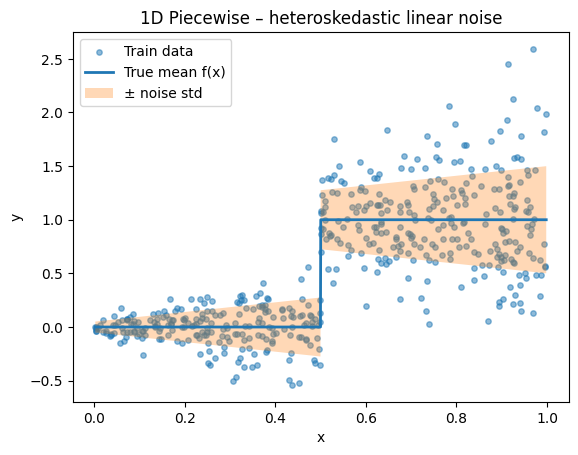

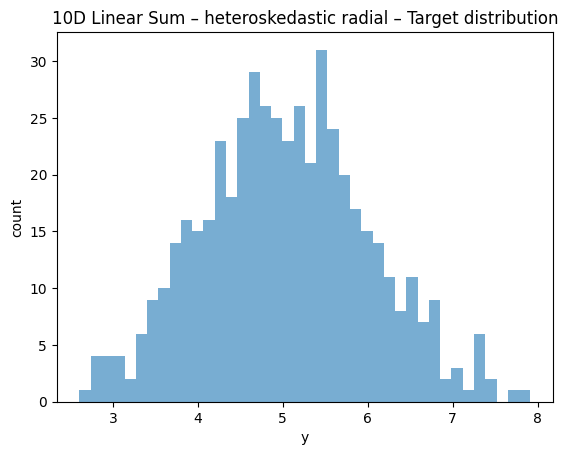

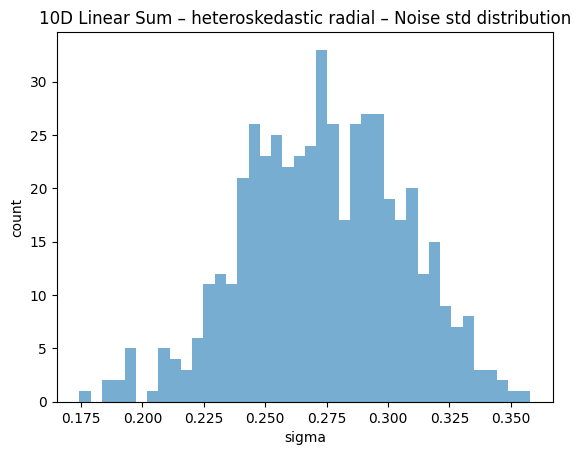

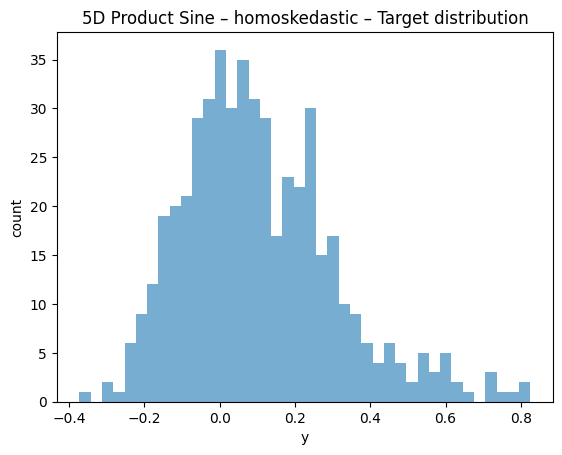

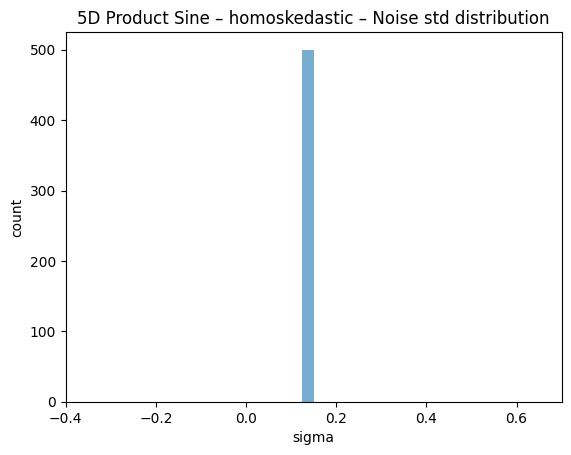

In [15]:
if __name__ == "__main__":
    # ---------------------------------
    # CONFIG 1: 1D, Sinus, homoskedastisch
    # ---------------------------------
    sine_1d_homo_config = DatasetConfig(
        d=1,
        k=20,
        mean_function=MEAN_FN_TYPE.SINE_1D,
        noise_type=NOISE_FN_TYPE.HOMO,
        sigma=0.2,
        seed=1
    )

    sine_1d_homo_data = generate_dataset(sine_1d_homo_config)


    # ---------------------------------
    # CONFIG 2: 10D, lineare Summe, heteroskedastisch radial
    # ---------------------------------
    linear_sum_10d_hetero_radial_config = DatasetConfig(
        d=10,
        k=50,
        mean_function=MEAN_FN_TYPE.SUM_LINEAR,
        noise_type=NOISE_FN_TYPE.HETERO_RADIAL,
        sigma_min=0.05,
        sigma_max=0.6,
        seed=2,
    )

    linear_sum_10d_hetero_radial_data = generate_dataset(
        linear_sum_10d_hetero_radial_config
    )


    # ---------------------------------
    # CONFIG 3: 5D, PRODUCT_SINE, homoskedastisch
    # ---------------------------------
    product_sine_5d_homo_config = DatasetConfig(
        d=5,
        k=30,
        mean_function=MEAN_FN_TYPE.PRODUCT_SINE,
        noise_type=NOISE_FN_TYPE.HOMO,
        sigma=0.15,
        seed=3
    )

    product_sine_5d_homo_data = generate_dataset(
        product_sine_5d_homo_config
    )


    # ---------------------------------
    # CONFIG 4: 1D, PIECEWISE, heteroskedastisch linear
    # ---------------------------------
    piecewise_1d_hetero_linear_config = DatasetConfig(
        d=1,
        k=10,
        mean_function=MEAN_FN_TYPE.PIECEWISE_1D,
        noise_type=NOISE_FN_TYPE.HETERO_LINEAR,
        sigma_min=0.05,
        sigma_max=0.5,
        seed=4
    )

    piecewise_1d_hetero_linear_data = generate_dataset(
        piecewise_1d_hetero_linear_config
    )


    # 1D plots
    plot_1d_dataset(
        sine_1d_homo_data,
        title="1D Sine – homoskedastic noise"
    )

    plot_1d_dataset(
        piecewise_1d_hetero_linear_data,
        title="1D Piecewise – heteroskedastic linear noise"
    )

    # High dimensional summaries
    plot_high_dim_summary(
        linear_sum_10d_hetero_radial_data,
        title="10D Linear Sum – heteroskedastic radial"
    )

    plot_high_dim_summary(
        product_sine_5d_homo_data,
        title="5D Product Sine – homoskedastic"
    )